In [3]:
from wandb.integration.keras import WandbMetricsLogger
from mlp_explainer import explainer, metrics
from scikeras.wrappers import KerasClassifier
from pgmpy.utils import get_example_model
from tensorflow import keras
import mlp_explainer
import numpy as np
import sklearn
import wandb
import copy

In [4]:
wandb.login()

True

In [7]:
from ucimlrepo import fetch_ucirepo 
  
car_evaluation = fetch_ucirepo(id = 19) 

X = car_evaluation.data.features.to_numpy()
y = car_evaluation.data.targets.to_numpy()

In [8]:
def build_model(input_shape, classes, n_layers = 5, n_nodes_l = 2, n_nodes_u = 10, optimizer = 'adam', learning_rate = 0.001):
    
    model = keras.Sequential()
    model.add(keras.Input(shape = (input_shape,)))
    for i in range(n_layers):
        model.add(keras.layers.Dense(np.random.choice([i for i in range(n_nodes_l, n_nodes_u)]), activation = np.random.choice(['relu', 'sigmoid'])))
    model.add(keras.layers.Dense(classes, activation = 'softmax'))

    if optimizer == 'sgd':
        optim = keras.optimizers.SGD(learning_rate = learning_rate)
    elif optimizer == 'adam':
        optim = keras.optimizers.Adam(learning_rate = learning_rate)
    
    model.compile(optimizer = optim, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
    
    return model

In [9]:
n_layers = 5
n_nodes_l = 5
n_nodes_u = 50
optimizer = 'adam'
learning_rate = 0.01
epochs = 25
batch_size = 64

In [10]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
    X, y, test_size = 0.1, random_state = 42, shuffle = True
)

In [11]:
feature_encoder = sklearn.preprocessing.OrdinalEncoder()
feature_encoder.fit(X_train)

target_encoder = sklearn.preprocessing.LabelEncoder()
target_encoder.fit(y_train.squeeze())

LabelEncoder()

In [12]:
X_train_proc = feature_encoder.transform(X_train)
y_train_proc = target_encoder.transform(y_train)

/home/vmuser/anaconda3/envs/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


In [13]:
n_classes = len(np.unique(y))
input_shape = len(X[0])

In [14]:
#wandb.init(entity = "computer-vision-wits", project = "MLP-E", name = "")
    
model = build_model(
    input_shape,
    n_classes,
    n_layers = n_layers, 
    n_nodes_l = n_nodes_l,
    n_nodes_u = n_nodes_u, 
    optimizer = optimizer, 
    learning_rate = learning_rate
)

'''
config = wandb.config
config.n_layers = n_layers
config.n_nodes_l = n_nodes_l
config.n_nodes_u = n_nodes_u
config.optimizer = optimizer
config.epochs = epochs
config.batch_size = batch_size
config.learning_rate = learning_rate
'''

model.fit(X_train_proc, y_train_proc, epochs = epochs, batch_size = batch_size, validation_split = 0.2)
model.summary()

#wandb.finish()

Epoch 1/25


2025-10-14 06:43:25.733356: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.6793 - loss: 0.8992 - val_accuracy: 0.6656 - val_loss: 0.9472
Epoch 2/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7162 - loss: 0.7705 - val_accuracy: 0.6656 - val_loss: 0.8357
Epoch 3/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7154 - loss: 0.6821 - val_accuracy: 0.6656 - val_loss: 0.7572
Epoch 4/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.7379 - loss: 0.6122 - val_accuracy: 0.7267 - val_loss: 0.6974
Epoch 5/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8352 - loss: 0.4727 - val_accuracy: 0.7910 - val_loss: 0.5435
Epoch 6/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8457 - loss: 0.4375 - val_accuracy: 0.7460 - val_loss: 0.6389
Epoch 7/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8441 - loss: 0.4281 - val_accuracy: 0.7910 - val_loss: 0.5513
Epoch 8/25
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.8497 - loss: 0.4091 - val_accuracy: 0.7685 - val_loss: 0.5898
Epo

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 21)             │           147 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 43)             │           946 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           440 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 24)             │           264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 36)             │           900 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           148 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,537 (33.35 KB)

 Trainable params: 2,845 (11.11 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 5,692 (22.24 KB)

In [15]:
X_test_proc = feature_encoder.transform(X_test)
y_test_proc = target_encoder.transform(y_test)

y_pred = model(X_test_proc)
y_pred = np.argmax(y_pred, axis = 1)
sklearn.metrics.accuracy_score(y_pred, y_test_proc)

/home/vmuser/anaconda3/envs/venv/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:129: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)


0.930635838150289

In [373]:
import numpy as np
import pandas as pd
from pgmpy.estimators import PC
from mlxtend.frequent_patterns import fpgrowth, association_rules

class Explainer:
    def __init__(self, model, X, preprocessor, n_samples = 100, rep_prob = 0.5):

        '''
        Args:
            model: model
            X: dataframe of X data (training, testing or all)
            preprocessor: function used to preprocess data prior to model forward pass
            n_samples: number of samples to generate for a single prediction explanation
            rep_prob: probability at which each feature value of x datapoint should be replaced with a value from a sample
        '''

        self.model = model
        self.X = X.to_numpy()
        self.preprocessor = preprocessor
        self.x_cols = X.columns
        self.y_col = 'target'
        self.n_samples = n_samples
        self.rep_prob = rep_prob

        self.bn = None
        self.data = None
        self.structure_data = None
        self.patterns = []
        self.relevance_dict = {col: 0 for col in self.x_cols}

    def __init_structures(self):
        
        self.data = None
        self.patterns = []
        
    def __data_generation(self, x: np.ndarray):

        y = self.model.predict(self.preprocessor(x.reshape(1, -1)), verbose=0).squeeze(0)
        y_argmax = y.argmax()
        
        random_indices = np.random.randint(len(self.X), size = self.n_samples)
        samples_X_base = self.X[random_indices]
        
        replace_mask = np.random.rand(self.n_samples, samples_X_base.shape[1]) < self.rep_prob
        
        samples_X_generated = np.where(replace_mask, x, samples_X_base)
        
        preprocessed_batch = self.preprocessor(samples_X_generated)
        
        samples_Y_raw = self.model.predict(preprocessed_batch, verbose=0)
        
        samples_Y_argmax = samples_Y_raw.argmax(axis=1)
        
        samples_Y_bool = samples_Y_argmax != y_argmax
        
        samples_X_bool = samples_X_generated != x
        
        samples_X_int = samples_X_bool.astype(int)
        samples_Y_int = samples_Y_bool.astype(int)
        
        self.data = pd.DataFrame(samples_X_int, columns = self.x_cols)
        self.data[self.y_col] = samples_Y_int
        
        self.structure_data = pd.concat([self.structure_data, self.data], ignore_index = True)

    def fp_growth(self, data, class_):

        if class_ == 0:
            data = 1 - data
            
        data = data.astype(bool)

        class_patterns = fpgrowth(data, min_support = 0.3, use_colnames = True)
        
        self.patterns.append(class_patterns)

    def __harmonic_merge(self):

        self.patterns[0] = self.patterns[0].rename(columns = {'support': 'support_stable'})
        self.patterns[1] = self.patterns[1].rename(columns = {'support': 'support_unstable'})
        
        patterns_merged = pd.merge(
            self.patterns[0],
            self.patterns[1],
            on = 'itemsets',
            how = 'outer'
        )
        
        patterns_merged = patterns_merged.fillna(0)
        
        support_0 = patterns_merged['support_stable']
        support_1 = patterns_merged['support_unstable']

        denominator = support_0 + support_1
        patterns_merged['Harmonic Mean'] = (2 * support_0 * support_1 / denominator).mask(denominator == 0, 0)
        
        harmonic_rank = patterns_merged[['itemsets', 'support_stable', 'support_unstable', 'Harmonic Mean']].sort_values(
            by = 'Harmonic Mean', 
            ascending = False
        )
        
        return harmonic_rank[harmonic_rank['Harmonic Mean'] > 0.0]

    def __relevance_rank(self):

        rank = self.__harmonic_merge()

        for row, idx in rank.iterrows():
    
            features = tuple(idx['itemsets'])
            h_mean = idx['Harmonic Mean']
            n_features = len(features)

            if n_features == 1:
                for feature in features:
                    self.relevance_dict[feature] += h_mean
        
        self.relevance_dict = dict(sorted(self.relevance_dict.items(), key = lambda item: item[1], reverse = True))

    def __structure_learning(self):

        data = self.structure_data[list(self.relevance_dict) + [self.y_col]].astype(str)
        est = PC(data = data)
        
        self.bn = est.estimate(ci_test = "chi_square", return_type = 'dag')

    def forward(self, x) -> None:

        self.__init_structures()
        self.__data_generation(x)
        
        for class_ in [0, 1]:
            
            class_data = self.data.loc[self.data[self.y_col] == class_]
            class_data = class_data.drop(self.y_col, axis = 1)
            self.fp_growth(class_data, class_)
        
        self.__relevance_rank()
        self.__structure_learning()

In [374]:
x_cols = car_evaluation.data.features.columns
y_col = car_evaluation.data.targets.columns[0]

def preprocessor(x):
    return feature_encoder.transform(x)

In [375]:
explainer = Explainer(
    model = model,
    X = car_evaluation.data.features,
    preprocessor = preprocessor,
    n_samples = 5000,
    rep_prob = 0.1
)

In [376]:
for _ in range(1):
    x = X_test[np.random.randint(len(X_test))]
    explainer.forward(x)

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'persons': 'C', 'safety': 'C', 'lug_boot': 'C', 'doors': 'C', 'buying': 'C', 'maint': 'C', 'target': 'C'}


      itemsets  support_stable  support_unstable  Harmonic Mean
0    (persons)        0.547276          1.000000       0.707405
1     (safety)        0.542468          1.000000       0.703377
24  (lug_boot)        0.439103          0.671975       0.531135
26     (doors)        0.322115          0.664809       0.433965
25    (buying)        0.311432          0.601911       0.410479


  0%|          | 0/5 [00:00<?, ?it/s]

INFO:pgmpy:Reached maximum number of allowed conditional variables. Exiting


In [370]:
# 1. safety 
# 2. persons 
# 3. buying 
# 4. maint 
# 5. lug_boot 
# 6. doors

In [371]:
explainer.relevance_dict

{'safety': 0.6940529391543485,
 'persons': 0.6902258231339424,
 'lug_boot': 0.5314212037613159,
 'buying': 0.49697047303404634,
 'doors': 0.4148592166715778,
 'maint': 0.3957099404503941}

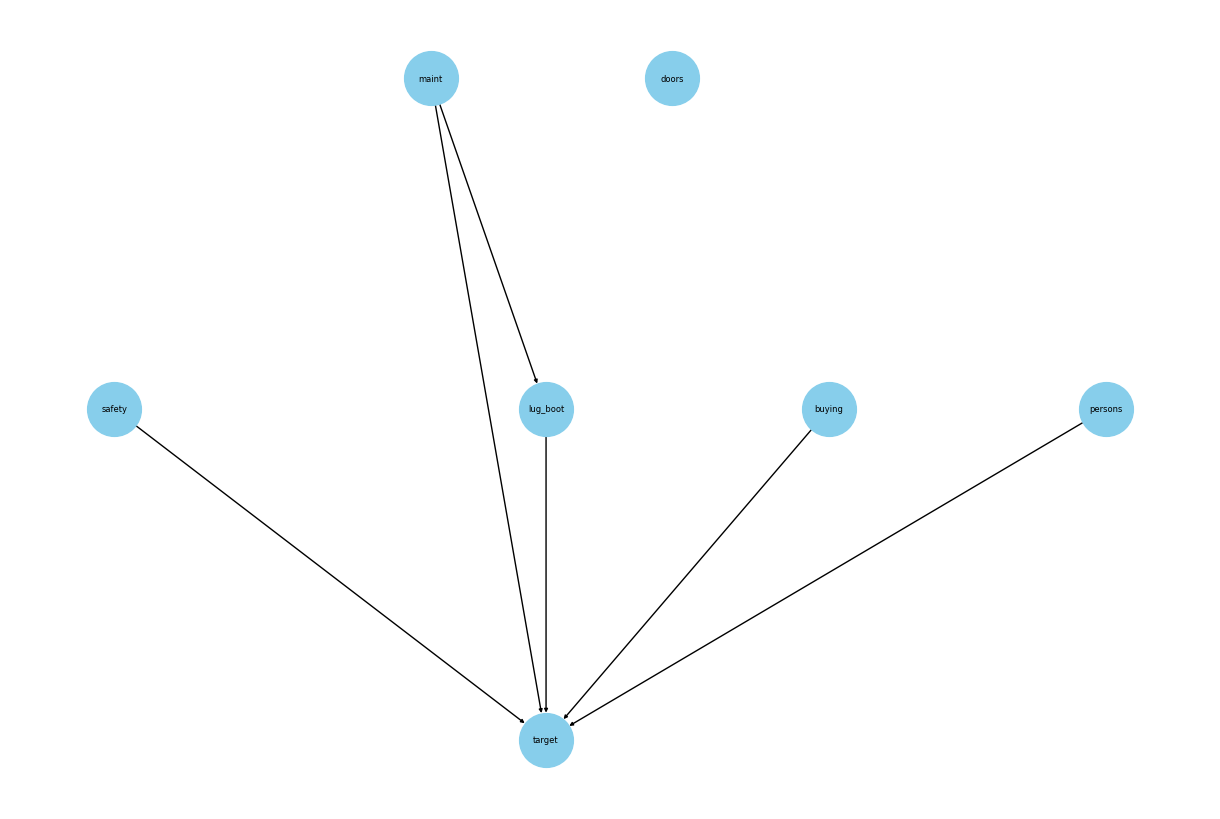

In [372]:
metrics.draw_network(explainer.bn)